In [1]:
!pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=efd7df6ab9abb9b749f6141b10d19b889802497367184efa65001170233d31ae
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge_score


In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import os
import torch
from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    DataCollatorForSeq2Seq,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
    EarlyStoppingCallback
)
from sklearn.model_selection import train_test_split
import re
from rouge_score import rouge_scorer
import warnings
from itertools import product

warnings.filterwarnings('ignore')
np.random.seed(42)
torch.manual_seed(42)

2025-07-24 06:19:53.332529: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753337993.533038      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753337993.592119      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
FILE_PATH = '/kaggle/input/indo-article-data-summarization/IndoData200.csv'
BEST_MODEL = "gaduhhartawan/indobart-base"
MAX_INPUT_LENGTH = 512
MAX_TARGET_LENGTH = 64
TRAIN_BATCH_SIZE = 4
EVAL_BATCH_SIZE = 4
NUM_TRAIN_EPOCHS = 4
RANDOM_STATE = 42

LEARNING_RATES = [1e-4, 2e-4]
WEIGHT_DECAYS = [0, 0.01]

os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


# Data Loading & Splitting

In [4]:
df = pd.read_csv(FILE_PATH)
print(f"Dataset loaded with {len(df)} samples")

train_df, temp_df = train_test_split(df, test_size=0.2, random_state=RANDOM_STATE)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=RANDOM_STATE)

print(f"Train set: {len(train_df)} samples")
print(f"Validation set: {len(val_df)} samples")
print(f"Test set: {len(test_df)} samples")

Dataset loaded with 200 samples
Train set: 160 samples
Validation set: 20 samples
Test set: 20 samples


# Creating HuggingFace Data

In [5]:
train_dataset = Dataset.from_pandas(train_df[['article', 'summary']].reset_index(drop=True))
val_dataset = Dataset.from_pandas(val_df[['article', 'summary']].reset_index(drop=True))
test_dataset = Dataset.from_pandas(test_df[['article', 'summary']].reset_index(drop=True))

dataset_dict = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset,
    'test': test_dataset
})

# Tokenization

In [6]:
def preprocess_function(examples, tokenizer, max_input_length, max_target_length):
    inputs = tokenizer(
        examples['article'],
        max_length=max_input_length,
        truncation=True,
        padding=False
    )

    with tokenizer.as_target_tokenizer():
        targets = tokenizer(
            examples['summary'],
            max_length=max_target_length,
            truncation=True,
            padding=False
        )

    inputs['labels'] = targets['input_ids']
    return inputs

# Compute Metrics

In [7]:
def compute_rouge_metrics(predictions, references):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge1_scores, rouge2_scores, rougeL_scores = [], [], []

    for pred, ref in zip(predictions, references):
        pred = str(pred).strip() if pred else " "
        ref = str(ref).strip() if ref else " "
        scores = scorer.score(ref, pred)
        rouge1_scores.append(scores['rouge1'].fmeasure)
        rouge2_scores.append(scores['rouge2'].fmeasure)
        rougeL_scores.append(scores['rougeL'].fmeasure)

    return {
        'rouge1': np.mean(rouge1_scores),
        'rouge2': np.mean(rouge2_scores),
        'rougeL': np.mean(rougeL_scores)
    }

def compute_metrics(eval_preds, tokenizer):
    predictions, labels = eval_preds

    if isinstance(predictions, tuple):
        predictions = predictions[0]
    
    predictions = np.where(predictions != -100, predictions, tokenizer.pad_token_id)
    vocab_size = len(tokenizer)
    predictions = np.clip(predictions, 0, vocab_size - 1)

    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    decoded_preds = [pred.strip() for pred in decoded_preds]
    decoded_labels = [label.strip() for label in decoded_labels]
    
    rouge_metrics = compute_rouge_metrics(decoded_preds, decoded_labels)
    return rouge_metrics

# Hyperparameter Tuning & Training

In [8]:
def tune_hyperparameters(model_name, dataset_dict, learning_rate, weight_decay, trial_num):
    print(f"\n{'='*80}\nTrial {trial_num}: Tuning {model_name}\n{'='*80}")
    print(f"Learning Rate: {learning_rate}")
    print(f"Weight Decay: {weight_decay}")
    print("-" * 40)

    # Load tokenizer and model
    tokenizer = AutoTokenizer.from_pretrained(model_name, legacy=False)
    model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

    # Handle tokenizer and model compatibility
    if model.config.vocab_size != len(tokenizer):
        print(f"Alert: Vocab size mismatch found for {model_name}.")
        print(f"  - Model config vocab size: {model.config.vocab_size}")
        print(f"  - Tokenizer vocab size:    {len(tokenizer)}")
        print("Resizing model token embeddings to match tokenizer.")
        model.resize_token_embeddings(len(tokenizer))
        
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
        model.config.pad_token_id = tokenizer.pad_token_id

    model.to(device)

    # Tokenize datasets
    tokenized_datasets = dataset_dict.map(
        lambda examples: preprocess_function(examples, tokenizer, MAX_INPUT_LENGTH, MAX_TARGET_LENGTH),
        batched=True,
        remove_columns=dataset_dict['train'].column_names
    )

    data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model, padding=True)

    # Create unique output directory for this trial
    output_dir = f'./results_trial_{trial_num}_lr_{learning_rate}_wd_{weight_decay}'.replace(".", "")
    logging_dir = f'./logs_trial_{trial_num}_lr_{learning_rate}_wd_{weight_decay}'.replace(".", "")

    training_args = Seq2SeqTrainingArguments(
        output_dir=output_dir,
        logging_dir=logging_dir,
        num_train_epochs=NUM_TRAIN_EPOCHS,
        per_device_train_batch_size=TRAIN_BATCH_SIZE,
        per_device_eval_batch_size=EVAL_BATCH_SIZE,
        learning_rate=learning_rate,
        weight_decay=weight_decay,
        warmup_steps=0,
        logging_strategy="epoch",
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="rougeL",
        greater_is_better=True,
        save_total_limit=1,
        predict_with_generate=True,
        generation_max_length=MAX_TARGET_LENGTH,
        generation_num_beams=2,
        fp16=torch.cuda.is_available(),
        report_to="none",
    )

    # Initialize trainer
    trainer = Seq2SeqTrainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_datasets['train'],
        eval_dataset=tokenized_datasets['validation'],
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=lambda eval_preds: compute_metrics(eval_preds, tokenizer),
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2, early_stopping_threshold=0.0)]
    )

    print("--- Starting training ---")
    trainer.train()

    print("\n--- Evaluating on test set ---")
    test_results = trainer.evaluate(eval_dataset=tokenized_datasets['test'], metric_key_prefix="test")

    print(f"\nTest Results for Trial {trial_num}:")
    print(f"  Learning Rate: {learning_rate}")
    print(f"  Weight Decay: {weight_decay}")
    print(f"  ROUGE-1: {test_results['test_rouge1']:.4f}")
    print(f"  ROUGE-2: {test_results['test_rouge2']:.4f}")
    print(f"  ROUGE-L: {test_results['test_rougeL']:.4f}")

    print("\n--- Generating sample predictions ---")
    sample_data = dataset_dict['test'].select(range(3))
    sample_tokenized = tokenized_datasets['test'].select(range(3))

    predictions = trainer.predict(sample_tokenized)
    decoded_preds = tokenizer.batch_decode(predictions.predictions, skip_special_tokens=True)

    for i, (article, reference, prediction) in enumerate(zip(
        sample_data['article'],
        sample_data['summary'],
        decoded_preds
    )):
        print(f"\nSample {i+1}:")
        print(f"| Article   |: {article[:150]}...")
        print(f"| Reference |: {reference}")
        print(f"| Prediction|: {prediction.strip()}")
        print("-" * 50)

    # Clean up GPU memory
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    return {
        'trial': trial_num,
        'model_name': model_name,
        'learning_rate': learning_rate,
        'weight_decay': weight_decay,
        'rouge1': test_results['test_rouge1'],
        'rouge2': test_results['test_rouge2'],
        'rougeL': test_results['test_rougeL']
    }

# Run

In [9]:
print(f"\n{'='*80}\nHYPERPARAMETER TUNING\n{'='*80}")
print(f"Model: {BEST_MODEL}")
print(f"Learning rate: {LEARNING_RATES}")
print(f"Weight decay: {WEIGHT_DECAYS}")

results = []
trial_num = 1

hyperparameter_combinations = list(product(LEARNING_RATES, WEIGHT_DECAYS))

for learning_rate, weight_decay in hyperparameter_combinations:
    result = tune_hyperparameters(BEST_MODEL, dataset_dict, learning_rate, weight_decay, trial_num)
    results.append(result)
    print(f"Successfully completed #{trial_num}")
    
    trial_num += 1


HYPERPARAMETER TUNING
Model: gaduhhartawan/indobart-base
Learning rate: [0.0001, 0.0002]
Weight decay: [0, 0.01]

Trial 1: Tuning gaduhhartawan/indobart-base
Learning Rate: 0.0001
Weight Decay: 0
----------------------------------------


config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/356 [00:00<?, ?B/s]

Alert: Vocab size mismatch found for gaduhhartawan/indobart-base.
  - Model config vocab size: 50264
  - Tokenizer vocab size:    50265
Resizing model token embeddings to match tokenizer.


The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Map:   0%|          | 0/160 [00:00<?, ? examples/s]

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

--- Starting training ---


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel
1,2.331500,2.194816,0.237161,0.078493,0.187266
2,1.491800,2.233896,0.284228,0.105200,0.225470
3,0.941300,2.405119,0.272865,0.090877,0.222770
4,0.549900,2.819915,0.242124,0.080110,0.195935


There were missing keys in the checkpoint model loaded: ['model.encoder.embed_tokens.weight', 'model.decoder.embed_tokens.weight', 'lm_head.weight'].



--- Evaluating on test set ---


early stopping required metric_for_best_model, but did not find eval_rougeL so early stopping is disabled



Test Results for Trial 1:
  Learning Rate: 0.0001
  Weight Decay: 0
  ROUGE-1: 0.2237
  ROUGE-2: 0.0742
  ROUGE-L: 0.1862

--- Generating sample predictions ---

Sample 1:
| Article   |: Apa yang terjadi saat manusia sekarat?.
Orang-orang sering mengira bahwa kehidupan adalah pertempuran melawan kematian. Tetapi apakah mungkin berdama...
| Reference |: Sejumlah orang mengatakan saat sekarat seseorang akan merasa bahagia. Apa itu benar?
| Prediction|: Orang-orang sering mengira bahwa kehidupan adalah pertempuran melawan kematian, karena apakah mungkin berdamai dengan kehid upan yang terjadi saat manusia sekar
--------------------------------------------------

Sample 2:
| Article   |: Tes darah rutin dapat deteksi kanker ovarium.
Uji coba ini akan mengubah metode deteksi tes darah Hasil uji coba ini dapat mengubah metode pemeriksaa...
| Reference |: Tes darah rutin dapat mendeteksi 86% kanker ovarium lebih awal sebelum masa dimana perempuan dapat didiagnosa memiliki sel kanker, menurut

Map:   0%|          | 0/160 [00:00<?, ? examples/s]

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

--- Starting training ---


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel
1,2.327300,2.242233,0.248685,0.087751,0.197476
2,1.471800,2.318436,0.276224,0.110437,0.223733
3,0.972000,2.354756,0.267460,0.094998,0.205239
4,0.568500,2.750229,0.237010,0.081074,0.183287


There were missing keys in the checkpoint model loaded: ['model.encoder.embed_tokens.weight', 'model.decoder.embed_tokens.weight', 'lm_head.weight'].



--- Evaluating on test set ---


early stopping required metric_for_best_model, but did not find eval_rougeL so early stopping is disabled



Test Results for Trial 2:
  Learning Rate: 0.0001
  Weight Decay: 0.01
  ROUGE-1: 0.2771
  ROUGE-2: 0.0944
  ROUGE-L: 0.2093

--- Generating sample predictions ---

Sample 1:
| Article   |: Apa yang terjadi saat manusia sekarat?.
Orang-orang sering mengira bahwa kehidupan adalah pertempuran melawan kematian. Tetapi apakah mungkin berdama...
| Reference |: Sejumlah orang mengatakan saat sekarat seseorang akan merasa bahagia. Apa itu benar?
| Prediction|: Orang-orang sering mengira bahwa kehidupan adalah pertempuran melawan kematian. Tetapi apakah mungkin berdamai dengan kemati, sebagian besar orang sedang meninggal.
--------------------------------------------------

Sample 2:
| Article   |: Tes darah rutin dapat deteksi kanker ovarium.
Uji coba ini akan mengubah metode deteksi tes darah Hasil uji coba ini dapat mengubah metode pemeriksaa...
| Reference |: Tes darah rutin dapat mendeteksi 86% kanker ovarium lebih awal sebelum masa dimana perempuan dapat didiagnosa memiliki sel kanker, 

Map:   0%|          | 0/160 [00:00<?, ? examples/s]

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

--- Starting training ---


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel
1,2.691600,2.510995,0.241169,0.081229,0.194917
2,1.790200,2.410808,0.259848,0.085815,0.198591
3,1.134300,2.573267,0.238583,0.084595,0.195029
4,0.620100,3.023135,0.231890,0.072350,0.185987


There were missing keys in the checkpoint model loaded: ['model.encoder.embed_tokens.weight', 'model.decoder.embed_tokens.weight', 'lm_head.weight'].



--- Evaluating on test set ---


early stopping required metric_for_best_model, but did not find eval_rougeL so early stopping is disabled



Test Results for Trial 3:
  Learning Rate: 0.0002
  Weight Decay: 0
  ROUGE-1: 0.2191
  ROUGE-2: 0.0791
  ROUGE-L: 0.1807

--- Generating sample predictions ---

Sample 1:
| Article   |: Apa yang terjadi saat manusia sekarat?.
Orang-orang sering mengira bahwa kehidupan adalah pertempuran melawan kematian. Tetapi apakah mungkin berdama...
| Reference |: Sejumlah orang mengatakan saat sekarat seseorang akan merasa bahagia. Apa itu benar?
| Prediction|: Orang-orang sering mengira bahwa kehidupan yang melawan kematian di berbagai daerah terbesar diperkirakan selama hari-hari terakhir, semakin dekat sese
--------------------------------------------------

Sample 2:
| Article   |: Tes darah rutin dapat deteksi kanker ovarium.
Uji coba ini akan mengubah metode deteksi tes darah Hasil uji coba ini dapat mengubah metode pemeriksaa...
| Reference |: Tes darah rutin dapat mendeteksi 86% kanker ovarium lebih awal sebelum masa dimana perempuan dapat didiagnosa memiliki sel kanker, menurut satu uji

Map:   0%|          | 0/160 [00:00<?, ? examples/s]

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

--- Starting training ---


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel
1,2.695100,2.485606,0.235972,0.076420,0.187981
2,1.780900,2.411320,0.257525,0.072416,0.196512
3,1.131400,2.584348,0.262031,0.080789,0.197909
4,0.604600,3.079316,0.236593,0.066559,0.185797


There were missing keys in the checkpoint model loaded: ['model.encoder.embed_tokens.weight', 'model.decoder.embed_tokens.weight', 'lm_head.weight'].



--- Evaluating on test set ---


early stopping required metric_for_best_model, but did not find eval_rougeL so early stopping is disabled



Test Results for Trial 4:
  Learning Rate: 0.0002
  Weight Decay: 0.01
  ROUGE-1: 0.2531
  ROUGE-2: 0.1030
  ROUGE-L: 0.1975

--- Generating sample predictions ---

Sample 1:
| Article   |: Apa yang terjadi saat manusia sekarat?.
Orang-orang sering mengira bahwa kehidupan adalah pertempuran melawan kematian. Tetapi apakah mungkin berdama...
| Reference |: Sejumlah orang mengatakan saat sekarat seseorang akan merasa bahagia. Apa itu benar?
| Prediction|: Orang-orang sering mengira bahwa kehidupan adalah pertempuran melawan kematian perawatan manusia, yang sebelumnya meninggal. Namun, sejumlah orang akan melalui
--------------------------------------------------

Sample 2:
| Article   |: Tes darah rutin dapat deteksi kanker ovarium.
Uji coba ini akan mengubah metode deteksi tes darah Hasil uji coba ini dapat mengubah metode pemeriksaa...
| Reference |: Tes darah rutin dapat mendeteksi 86% kanker ovarium lebih awal sebelum masa dimana perempuan dapat didiagnosa memiliki sel kanker, menur


HYPERPARAMETER TUNING RESULTS
Results sorted by ROUGE-L score:
 trial                  model_name  learning_rate  weight_decay   rouge1   rouge2   rougeL
     2 gaduhhartawan/indobart-base         0.0001          0.01 0.277090 0.094385 0.209274
     4 gaduhhartawan/indobart-base         0.0002          0.01 0.253078 0.103032 0.197460
     1 gaduhhartawan/indobart-base         0.0001          0.00 0.223694 0.074153 0.186196
     3 gaduhhartawan/indobart-base         0.0002          0.00 0.219092 0.079061 0.180716

BEST HYPERPARAMETERS:
Learning Rate: 0.0001
Weight Decay: 0.01
Best ROUGE-1: 0.2771
Best ROUGE-2: 0.0944
Best ROUGE-L: 0.2093


<Figure size 1200x800 with 0 Axes>

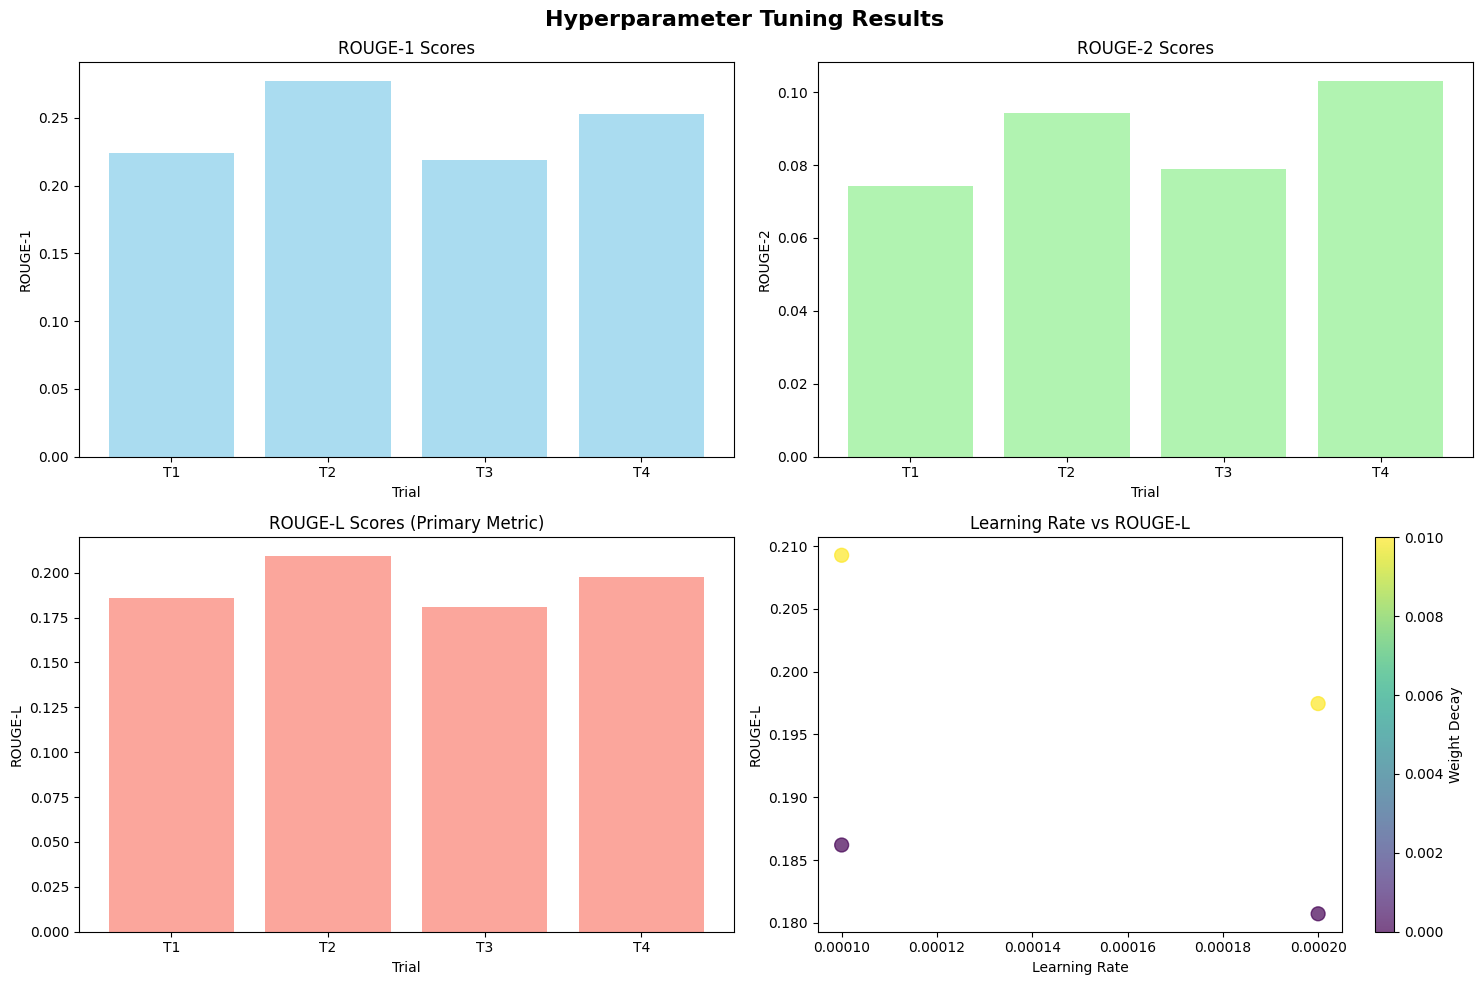

In [15]:
print(f"\n{'='*80}\nHYPERPARAMETER TUNING RESULTS\n{'='*80}")

results_df = pd.DataFrame(results)
sort_results_df = results_df.sort_values('rougeL', ascending=False).reset_index(drop=True)

print("Results sorted by ROUGE-L score:")
print(sort_results_df.to_string(index=False))

best_result = sort_results_df.iloc[0]
print(f"\nBEST HYPERPARAMETERS:")
print(f"Learning Rate: {best_result['learning_rate']}")
print(f"Weight Decay: {best_result['weight_decay']}")
print(f"Best ROUGE-1: {best_result['rouge1']:.4f}")
print(f"Best ROUGE-2: {best_result['rouge2']:.4f}")
print(f"Best ROUGE-L: {best_result['rougeL']:.4f}")

# Save results to CSV
csv_filename = 'hyperparameter_tuning_results.csv'
sort_results_df.to_csv(csv_filename, index=False)

plt.figure(figsize=(12, 8))
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Hyperparameter Tuning Results', fontsize=16, fontweight='bold')

# ROUGE-1 scores
axes[0, 0].bar(range(len(results_df)), results_df['rouge1'], color='skyblue', alpha=0.7)
axes[0, 0].set_title('ROUGE-1 Scores')
axes[0, 0].set_xlabel('Trial')
axes[0, 0].set_ylabel('ROUGE-1')
axes[0, 0].set_xticks(range(len(results_df)))
axes[0, 0].set_xticklabels([f"T{i+1}" for i in range(len(results_df))])

# ROUGE-2 scores
axes[0, 1].bar(range(len(results_df)), results_df['rouge2'], color='lightgreen', alpha=0.7)
axes[0, 1].set_title('ROUGE-2 Scores')
axes[0, 1].set_xlabel('Trial')
axes[0, 1].set_ylabel('ROUGE-2')
axes[0, 1].set_xticks(range(len(results_df)))
axes[0, 1].set_xticklabels([f"T{i+1}" for i in range(len(results_df))])

# ROUGE-L scores
axes[1, 0].bar(range(len(results_df)), results_df['rougeL'], color='salmon', alpha=0.7)
axes[1, 0].set_title('ROUGE-L Scores (Primary Metric)')
axes[1, 0].set_xlabel('Trial')
axes[1, 0].set_ylabel('ROUGE-L')
axes[1, 0].set_xticks(range(len(results_df)))
axes[1, 0].set_xticklabels([f"T{i+1}" for i in range(len(results_df))])

# Hyperparameter comparison
axes[1, 1].scatter(results_df['learning_rate'], results_df['rougeL'], 
                  c=results_df['weight_decay'], cmap='viridis', s=100, alpha=0.7)
axes[1, 1].set_title('Learning Rate vs ROUGE-L')
axes[1, 1].set_xlabel('Learning Rate')
axes[1, 1].set_ylabel('ROUGE-L')
cbar = plt.colorbar(axes[1, 1].collections[0], ax=axes[1, 1])
cbar.set_label('Weight Decay')

plt.tight_layout()